In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import logging
import datetime
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
# Tokenizer and stemmer initialized once
stemmer = PorterStemmer()
import concurrent.futures
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import tensorflow as tf
import contractions, re
import string
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
from nltk.tokenize import sent_tokenize
import spacy
# Loading Spacy small model as nlp
nlp = spacy.load('en_core_web_sm')
from collections import Counter
from wordcloud import WordCloud
import math
# import warnings
# warnings.filterwarnings("ignore")


##  Exploratory Data Analysis (EDA)
Understand the dataset scope and focus on the most frequent tickers for efficiency.

In [3]:
transcripts_data = pd.read_pickle("motley-fool-data.pkl")

**remove duplicated transcripts**

In [4]:
transcripts_data=transcripts_data[~transcripts_data.duplicated(["transcript"])].reset_index(drop=True)

In [5]:
transcripts_data.describe()

,date,exchange,q,ticker,transcript
count,17592,17592,17592,17592,17592
unique,6053,2879,25,2876,17592
top,"Nov 4, 2021, 5:00 p.m. ET",NASDAQ: GOOGL,2021-Q3,ACM,"Prepared Remarks:\nOperator\nGood day, and wel..."
freq,49,15,2319,15,1


### Clean and format transcripts data column 

In [8]:
# Expanding contractions
transcripts_data["transcript_preproc"] = transcripts_data["transcript"].apply(lambda x: contractions.fix(x))

In [9]:
def clean_text(text):

    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove non-English characters
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    text = text.lower() # Convert to lowercase
    return text

In [10]:
transcripts_data['transcript_preproc'] =transcripts_data['transcript'].map(clean_text)

In [11]:
transcripts_data.head()

,date,exchange,q,ticker,transcript,transcript_preproc
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel...",prepared remarks operator good day and welcome...
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...,prepared remarks operator thank you for standi...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...,prepared remarks operator good day and welcome...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon...",prepared remarks operator good day everyone an...
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...,prepared remarks operator greetings and welcom...


### Word Count Distribution

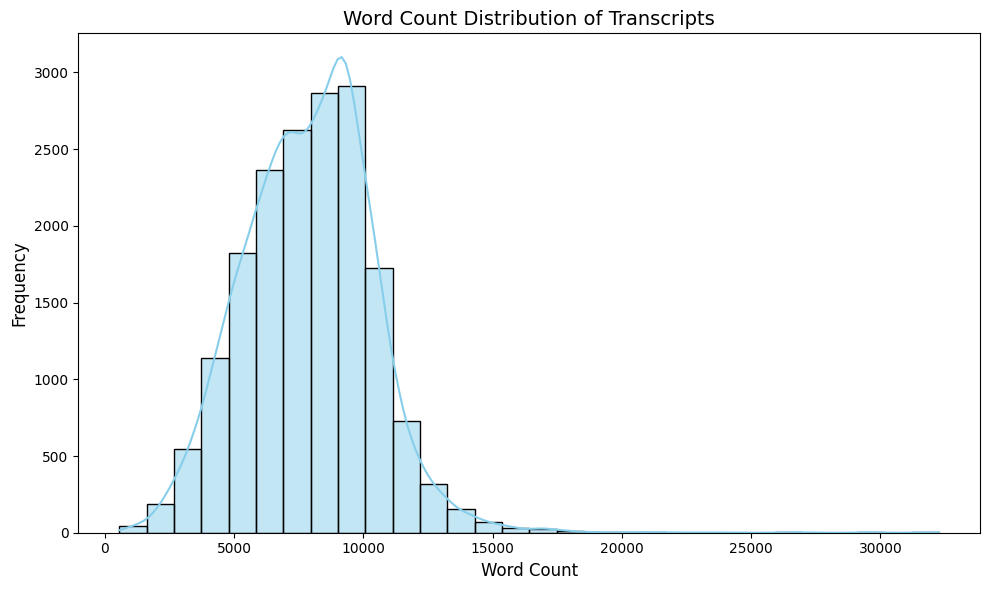

In [19]:
# Histogram of transcript lengths (word counts)
plt.figure(figsize=(10, 6))
sns.histplot(transcripts_data['word_count'], bins=30, kde=True, color='skyblue')
plt.title("Word Count Distribution of Transcripts", fontsize=14)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

### Most Frequent Words (Excluding Stop Words)

Processing the data in batches for more efficient data handling.

In [26]:
def get_most_frequent_words_in_batches(transcripts_data, batch_size=100, top_n=10):
    
    stop_words = set(stopwords.words('english'))
    all_words = Counter()

    # Total number of batches
    total_batches = math.ceil(len(transcripts_data) / batch_size)

    for batch_idx in range(total_batches):
        # Get a batch of transcripts
        batch = transcripts_data.iloc[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # Process each transcript in the batch
        for transcript in batch['transcript']:
            # Tokenize and filter stop words
            tokens = word_tokenize(transcript.lower())
            filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
            all_words.update(filtered_words)  # Update the Counter with filtered words

    # Get the top N most frequent words
    top_words = all_words.most_common(top_n)
    return top_words

/var/folders/5h/1cc6fvqn1nsf3cqhcndrlz280000gn/T/ipykernel_79408/2791985529.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words_df, x='count', y='word', palette='coolwarm')


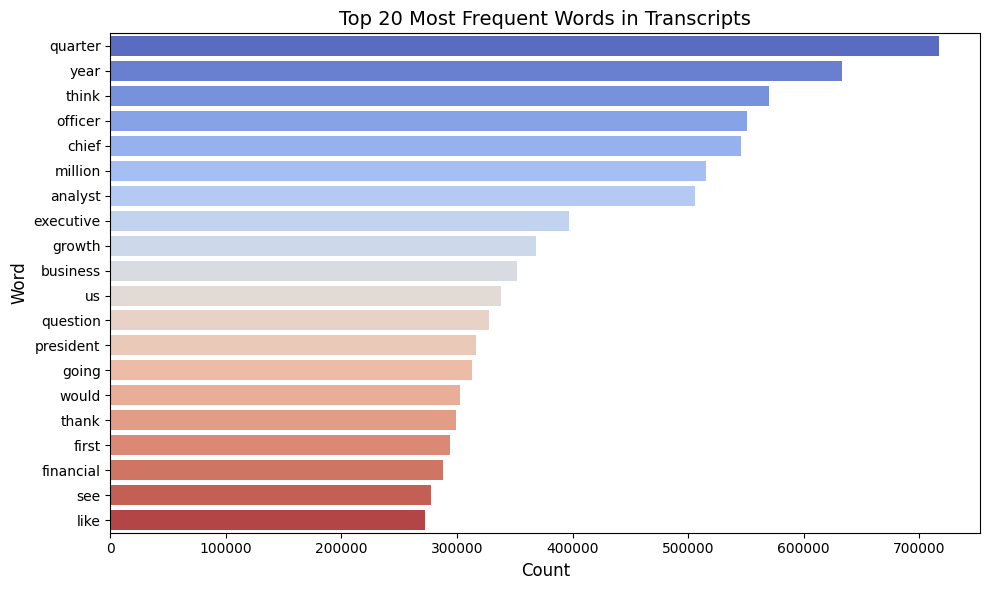

In [29]:
batch_size = 500
top_n = 20

# Get the most frequent words
top_words = get_most_frequent_words_in_batches(transcripts_data, batch_size=batch_size, top_n=top_n)

# Create a DataFrame for plotting
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=top_words_df, x='count', y='word', palette='coolwarm')
plt.title("Top 20 Most Frequent Words in Transcripts", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.tight_layout()
plt.show()


**Word Cloud of all most frequent words and most frequent custom financial vocabulary**

We need this for the relevant sentences extraction.

In [30]:
all_cleaned_text = " ".join(transcripts_data['transcript_preproc'])

In [31]:
financial_terms = {"revenue", "profit", "growth", "loss", "income", "expenses", "margin", "quarter", "increased", "capital", "expect", "earnings", "market", "turn", "results"}


In [32]:
# additional custom stopwords to remove
custom_stopwords = {"quarter", "year", "think", "us", "executive", "chief", "analyst","officer","thats","thank","like","see","would","question"}

def get_word_frequencies(text):
    """ Tokenize text into words and count frequency, excluding stopwords. """
    words = text.split()
    stop_words = set(stopwords.words('english')).union(custom_stopwords)
    words = [word for word in words if word not in stop_words]
    return Counter(words)

def process_batch(batch_data):
    """ Process a batch of transcripts and return a combined word frequency Counter. """
    all_word_frequencies = Counter()
    for transcript in batch_data:
        word_frequencies = get_word_frequencies(transcript)
        all_word_frequencies.update(word_frequencies)
    return all_word_frequencies


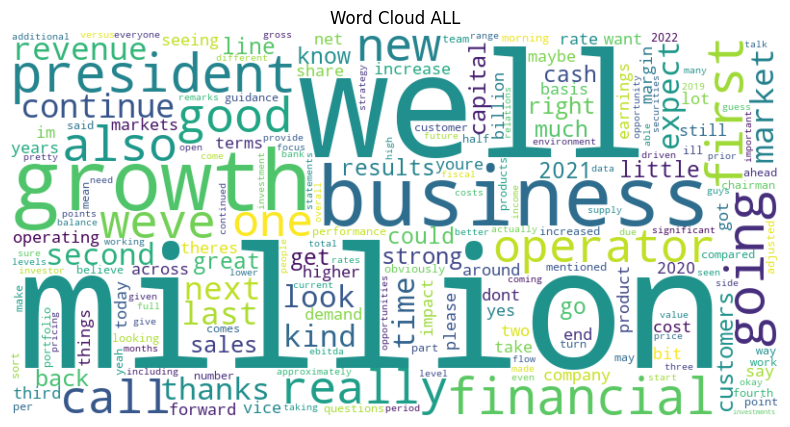

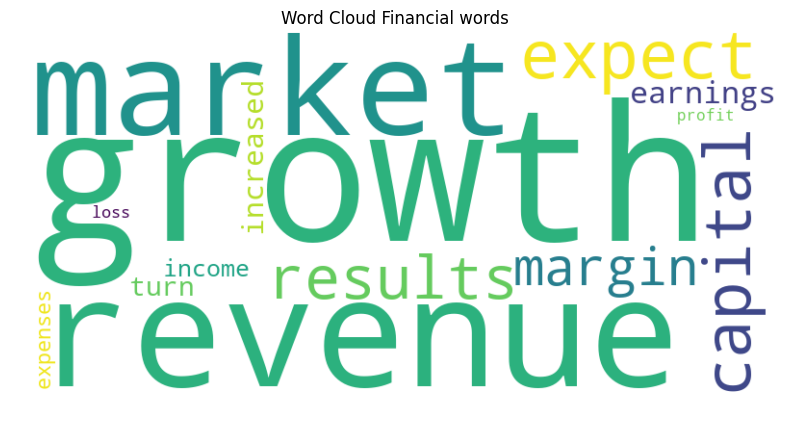

In [33]:
# Split the dataset into batches
batch_size = 500  # Adjust this depending on available memory
batches = [transcripts_data['transcript_preproc'][i:i + batch_size] for i in range(0, len(transcripts_data), batch_size)]

# Initialize a Counter to accumulate frequencies across batches
final_word_frequencies = Counter()

# Process each batch and accumulate word frequencies
for batch in batches:
    batch_word_frequencies = process_batch(batch)
    final_word_frequencies.update(batch_word_frequencies)

# Generate the Word Cloud from the accumulated frequencies
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(final_word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud ALL")
plt.show()

# Filter for financial terms

financial_word_frequencies = {word: count for word, count in final_word_frequencies.items() if word in financial_terms}

if financial_word_frequencies:
    financial_wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(financial_word_frequencies)
    
    # Display the word cloud for financial terms
   
    plt.figure(figsize=(10, 5))
    plt.imshow(financial_wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud Financial words")
    plt.show()
else:
    print("No financial terms found in the data.")

### Most frequent tickers by the number of earning meetings

/var/folders/5h/1cc6fvqn1nsf3cqhcndrlz280000gn/T/ipykernel_79408/2543537682.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticker_counts.index, y=ticker_counts.values, palette='viridis', hue=None, dodge=False, legend=False)


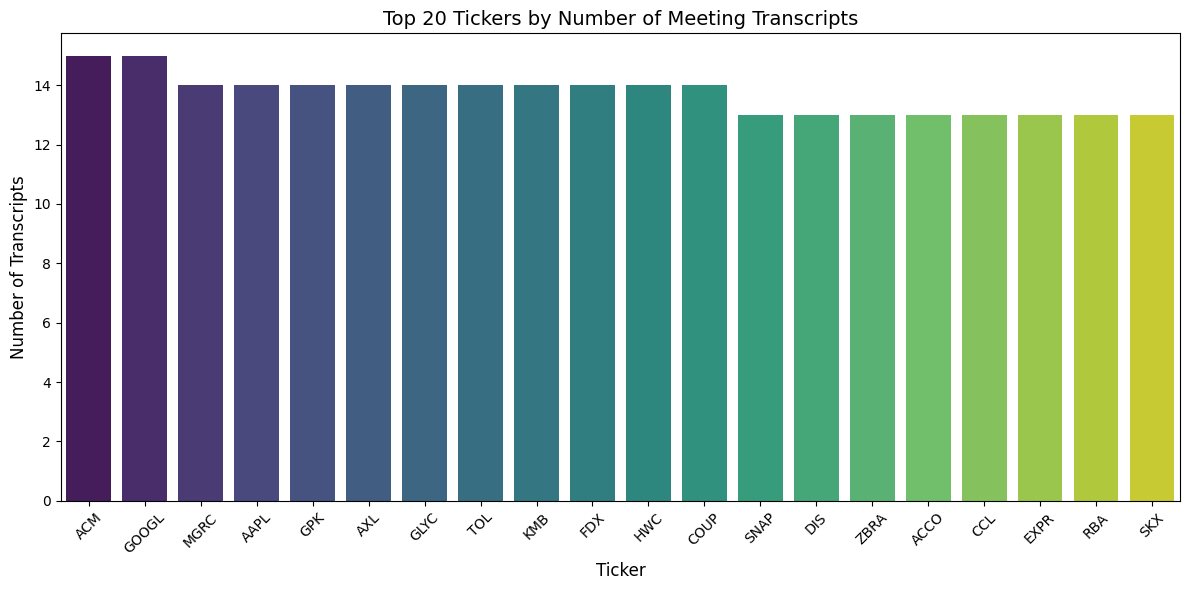

/var/folders/5h/1cc6fvqn1nsf3cqhcndrlz280000gn/T/ipykernel_79408/2543537682.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Summary of Data Distribution for Top 20 Tickers:
        average_word_count  total_transcripts
ticker                                       
GOOGL          8230.133333                 15
ACM            9100.400000                 15
MGRC           5231.214286                 14
GLYC           5112.642857                 14
COUP           9217.428571                 14
TOL            9777.714286                 14
GPK           12035.714286                 14
FDX            9605.928571                 14
AXL            8558.571429                 14
AAPL           8463.785714                 14
KMB            9961.785714                 14
HWC            7342.357143                 14
DLB            7225.307692                 13
ACCO           6967.769231                 13
SKX            9631.230769                 13
WDFC           7273.769231                 13
WOR            4787.538462                 13
SNAP           9588.692308                 13
FHB            6094.615385    

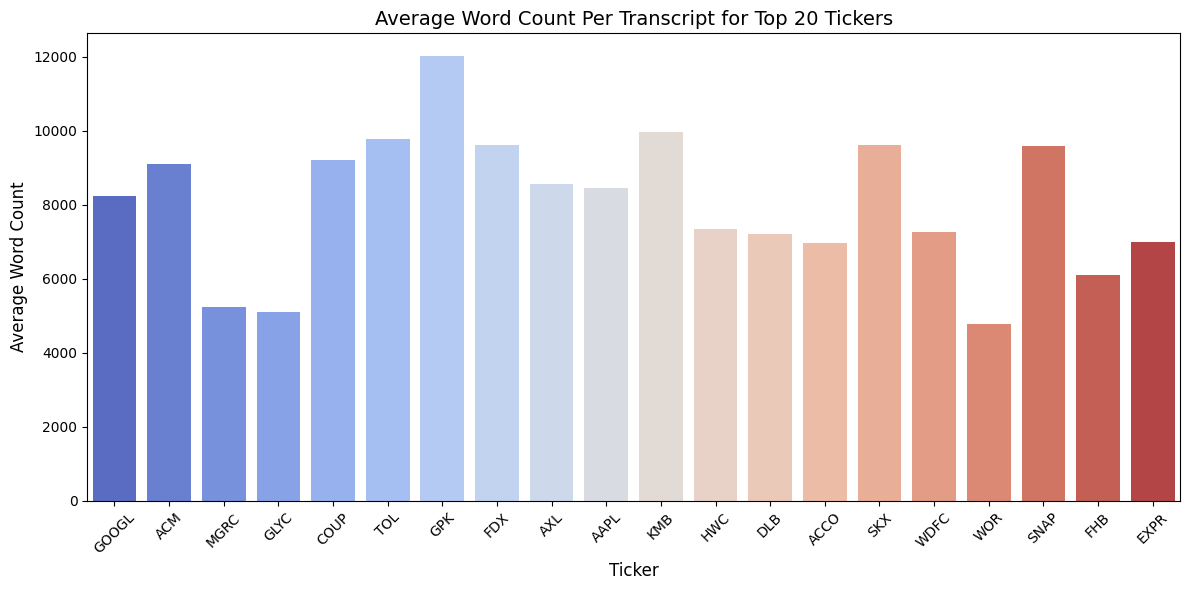

In [16]:
transcripts_data['word_count'] = transcripts_data['transcript_preproc'].apply(lambda x: len(x.split()))

# top 20 tickers by the number of meeting transcripts

ticker_counts = transcripts_data['ticker'].value_counts().head(20)

# bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=ticker_counts.index, y=ticker_counts.values, palette='viridis', hue=None, dodge=False, legend=False)
plt.title("Top 20 Tickers by Number of Meeting Transcripts", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Number of Transcripts", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summarize the data distribution, average word count and display
summary_stats = transcripts_data.groupby('ticker').agg(
    average_word_count=('word_count', 'mean'),
    total_transcripts=('transcript_preproc', 'count')
).sort_values(by='total_transcripts', ascending=False).head(20)

print("\nSummary of Data Distribution for Top 20 Tickers:")
print(summary_stats)

# Plot the average word count per transcript for the top 20 tickers
plt.figure(figsize=(12, 6))
sns.barplot(
    x=summary_stats.index, 
    y=summary_stats['average_word_count'], 
    palette='coolwarm'
)
plt.title("Average Word Count Per Transcript for Top 20 Tickers", fontsize=14)
plt.xlabel("Ticker", fontsize=12)
plt.ylabel("Average Word Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
most_freq_tickers_meetings = transcripts_data.groupby("ticker")["date"].count().sort_values(ascending=False)

In [39]:
most_freq_tickers_meetings = most_freq_tickers_meetings.head(20).index.to_list()

In [40]:
most_freq_tickers_meetings

['GOOGL',
 'ACM',
 'MGRC',
 'GLYC',
 'COUP',
 'TOL',
 'GPK',
 'FDX',
 'AXL',
 'AAPL',
 'KMB',
 'HWC',
 'DLB',
 'ACCO',
 'SKX',
 'WDFC',
 'WOR',
 'SNAP',
 'FHB',
 'EXPR']

We continue the analysis with only these 20 tickers as they have most meeting transcripts

In [41]:
transcripts_data_top20 = transcripts_data[transcripts_data["ticker"].isin(most_freq_tickers_meetings)]

## Sentiment Analysis using FinBERT

In [42]:
# Load FinBERT and Tokenizer
finbert = TFBertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

# Function to apply FinBERT sentiment analysis directly on the text
def get_sentiment_from_finbert(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    
    # Get the sentiment predictions (FinBERT outputs logits)
    logits = finbert(**inputs).logits
    
    # Convert logits to probabilities
    sentiment = tf.nn.softmax(logits, axis=-1)
    
    # The model outputs three classes: 'negative', 'neutral', 'positive'
    sentiment_score = tf.argmax(sentiment, axis=-1).numpy()[0]  # Convert to numpy and get the first value
    
    return sentiment_score  # 0 = negative, 1 = neutral, 2 = positive


Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [43]:
def split_text_into_chunks(text, max_tokens=512):
    tokens = tokenizer.encode(text)
    for i in range(0, len(tokens), max_tokens):
        yield tokenizer.decode(tokens[i:i + max_tokens])

def get_sentiment_from_long_text(text):
    chunks = list(split_text_into_chunks(text))
    sentiment_scores = []
    
    for chunk in chunks:
        inputs = tokenizer(chunk, max_length=512, truncation=True, padding=True, return_tensors="tf")
        logits = finbert(**inputs).logits
        sentiment = tf.nn.softmax(logits, axis=-1)
        sentiment_scores.append(tf.argmax(sentiment, axis=-1).numpy()[0])
    
    # Aggregate sentiment scores (e.g., majority voting)
    final_sentiment = max(set(sentiment_scores), key=sentiment_scores.count)
    return final_sentiment


In [44]:
transcripts_data_top20['finbert_sentiment'] = transcripts_data_top20['transcript_preproc'].apply(get_sentiment_from_long_text)

KeyboardInterrupt: 

### Key Sentences extraction

Using the Word Cloud of all most frequent words we create a frequent custom financial vocabulary

In [46]:
# Filter for financial terms
financial_terms = {"revenue", "profit", "growth", "loss", "income", "expenses", "margin", "quarter", "increased", "capital", "expect", "earnings", "market", "turn", "results"}



In [48]:
# Function to extract key sentences (financial terms) from a text
def extract_key_sentences_batch(text, financial_terms, batch_size=5000):
    sentences = sent_tokenize(text)
    key_sentences_batch = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        key_sentences_batch.extend([sentence for sentence in batch if any(term in sentence.lower() for term in financial_terms)])

    return key_sentences_batch

# Apply batch key sentence extraction to each transcript in the DataFrame
transcripts_data_top20['key_sentences'] = transcripts_data_top20['transcript_preproc'].apply(lambda x: extract_key_sentences_batch(x, financial_terms))

# View the first few rows with the extracted key sentences
print(transcripts_data_top20[['key_sentences']].head())


                                         key_sentences
22   [prepared remarks operator good day ladies and...
46   [prepared remarks operator good day everyone w...
157  [prepared remarks operator ladies and gentleme...
161  [prepared remarks operator good morning and we...
163  [prepared remarks operator good afternoon ever...


/var/folders/5h/1cc6fvqn1nsf3cqhcndrlz280000gn/T/ipykernel_79408/296389807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_data_top20['key_sentences'] = transcripts_data_top20['transcript_preproc'].apply(lambda x: extract_key_sentences_batch(x, financial_terms))


In [49]:
def analyze_sentiment_on_key_sentences(transcripts_data):
    sentiment_results = []

    for idx, row in transcripts_data.iterrows():
        key_sentences = row['key_sentences']  # Get the list of key sentences
        
        if not key_sentences:
            sentiment_results.append(None)  # No key sentences found
            continue
        
        # Apply sentiment analysis to each key sentence
        sentiment_scores = []
        for sentence in key_sentences:
            # If the sentence is too long, break it into smaller chunks
            if len(tokenizer.encode(sentence)) > 512:
                # Split the sentence into chunks of 512 tokens
                chunks = [sentence[i:i+512] for i in range(0, len(sentence), 512)]
                for chunk in chunks:
                    sentiment_scores.append(get_sentiment_from_finbert(chunk))
            else:
                sentiment_scores.append(get_sentiment_from_finbert(sentence))
        
        # Aggregate the sentiment scores using majority voting
        final_sentiment = max(set(sentiment_scores), key=sentiment_scores.count)
        
        sentiment_results.append(final_sentiment)
    
    return sentiment_results

In [74]:
# Apply the function to the entire dataframe
transcripts_data_top20['key_sentences_sentiment'] = analyze_sentiment_on_key_sentences(transcripts_data_top20)

KeyboardInterrupt: 

**I did the sentiment analysis in a diff notebook so I upload the file here only**

In [75]:
transcripts_data_top20 = pd.read_csv("top20tickersSentAnal.csv", index_col=0).reset_index(drop=True)

In [76]:
transcripts_data_top20

,date,exchange,q,ticker,transcript,transcript_preproc,transcript_tokens,finbert_sentiment,key_sentences,key_sentences_sentiment
0,"Mar 16, 2021, 4:30 p.m. ET",NASDAQ: COUP,2021-Q4,COUP,"Prepared Remarks:\nOperator\nGood day, ladies ...",prepared remarks operator good day ladies gent...,"['prepar', 'remark', 'oper', 'good', 'day', 'l...",1,['prepared remarks operator good day ladies ge...,1
1,"Apr 30, 2020, 5:00 p.m. ET",NASDAQ: AAPL,2020-Q2,AAPL,"Prepared Remarks:\nOperator\nGood day, everyon...",prepared remarks operator good day everyone we...,"['prepar', 'remark', 'oper', 'good', 'day', 'e...",1,['prepared remarks operator good day everyone ...,1
2,"Jan 25, 2021, 10:00 a.m. ET",NYSE: KMB,2020-Q4,KMB,Prepared Remarks:\nOperator\nLadies and gentle...,prepared remarks operator ladies gentlemen tha...,"['prepar', 'remark', 'oper', 'ladi', 'gentleme...",1,['prepared remarks operator ladies gentlemen t...,1
3,"['AECOM Technology (ACM 0.87%) Q1 2019 ', 'Feb...",NYSE: ACM,2019-Q1,ACM,Prepared Remarks:\nOperator\nGood morning and ...,prepared remarks operator good morning welcome...,"['prepar', 'remark', 'oper', 'good', 'morn', '...",1,['prepared remarks operator good morning welco...,1
4,"Feb 03, 2022, 5:00 p.m. ET",NYSE: SNAP,2021-Q4,SNAP,"Prepared Remarks:\nOperator\nGood afternoon, e...",prepared remarks operator good afternoon every...,"['prepar', 'remark', 'oper', 'good', 'afternoo...",1,['prepared remarks operator good afternoon eve...,1
...,...,...,...,...,...,...,...,...,...,...
269,"Feb 03, 2022, 4:30 p.m. ET",NYSE: SKX,2021-Q4,SKX,Prepared Remarks:\nOperator\nThank you for sta...,prepared remarks operator thank standing confe...,"['prepar', 'remark', 'oper', 'thank', 'stand',...",1,['prepared remarks operator thank standing con...,1
270,"Oct 27, 2022, 5:00 p.m. ET",NASDAQ: AAPL,2022-Q4,AAPL,"Prepared Remarks:\nOperator\nGood day, and wel...",prepared remarks operator good day welcome app...,"['prepar', 'remark', 'oper', 'good', 'day', 'w...",1,['prepared remarks operator good day welcome a...,1
271,"Apr 22, 2022, 5:00 p.m. ET",NASDAQ: FHB,2022-Q1,FHB,"Prepared Remarks:\nOperator\nGood day, and tha...",prepared remarks operator good day thank stand...,"['prepar', 'remark', 'oper', 'good', 'day', 't...",1,['prepared remarks operator good day thank sta...,0
272,"Sep 29, 2021, 2:30 p.m. ET",NYSE: WOR,2022-Q1,WOR,Prepared Remarks:\nOperator\nGood afternoon an...,prepared remarks operator good afternoon welco...,"['prepar', 'remark', 'oper', 'good', 'afternoo...",0,['prepared remarks operator good afternoon wel...,0


### Compare sentiment analysis of full transcript vs summarised transcript of relevant sentences

In [77]:
sentiment_over_time = transcripts_data_top20.groupby(['q','ticker'])[['finbert_sentiment', 'key_sentences_sentiment']].mean().reset_index()
sentiment_over_time

,q,ticker,finbert_sentiment,key_sentences_sentiment
0,2017-Q4,ACM,1.0,1.0
1,2017-Q4,GOOGL,1.0,1.0
2,2017-Q4,TOL,1.0,0.0
3,2018-Q2,KMB,1.0,0.0
4,2018-Q2,TOL,0.0,0.0
...,...,...,...,...
267,2023-Q1,FDX,1.0,0.0
268,2023-Q1,WDFC,1.0,1.0
269,2023-Q1,WOR,0.0,1.0
270,2023-Q2,COUP,1.0,0.0


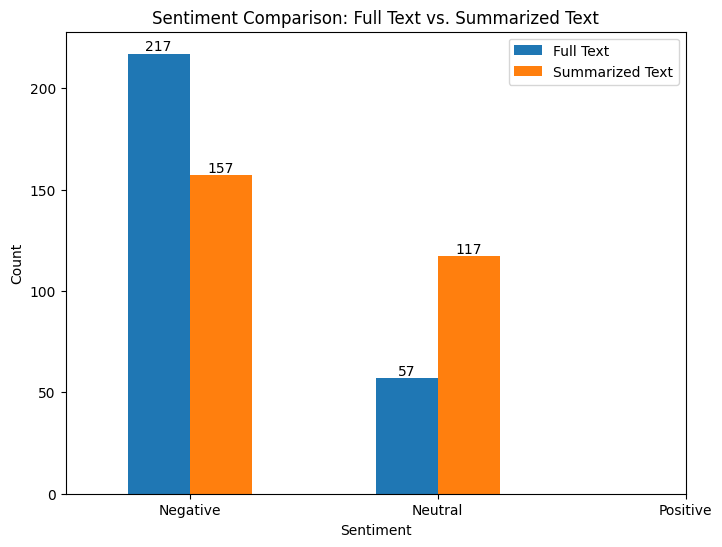

In [78]:
# Create sentiment counts for full and summarized text
full_text_sentiment_counts = transcripts_data_top20['finbert_sentiment'].value_counts()
summarized_sentiment_counts = transcripts_data_top20['key_sentences_sentiment'].value_counts()

# Combine into a DataFrame for easier plotting
sentiment_counts = pd.DataFrame({
    'Full Text': full_text_sentiment_counts,
    'Summarized Text': summarized_sentiment_counts
}).fillna(0)

# Plot the bar chart with sentiment categories on the x-axis
ax = sentiment_counts.plot(kind='bar', figsize=(8, 6))

# Add annotations (numbers) on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)

# Add title and labels
plt.title('Sentiment Comparison: Full Text vs. Summarized Text')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)

# Show the plot
plt.show()

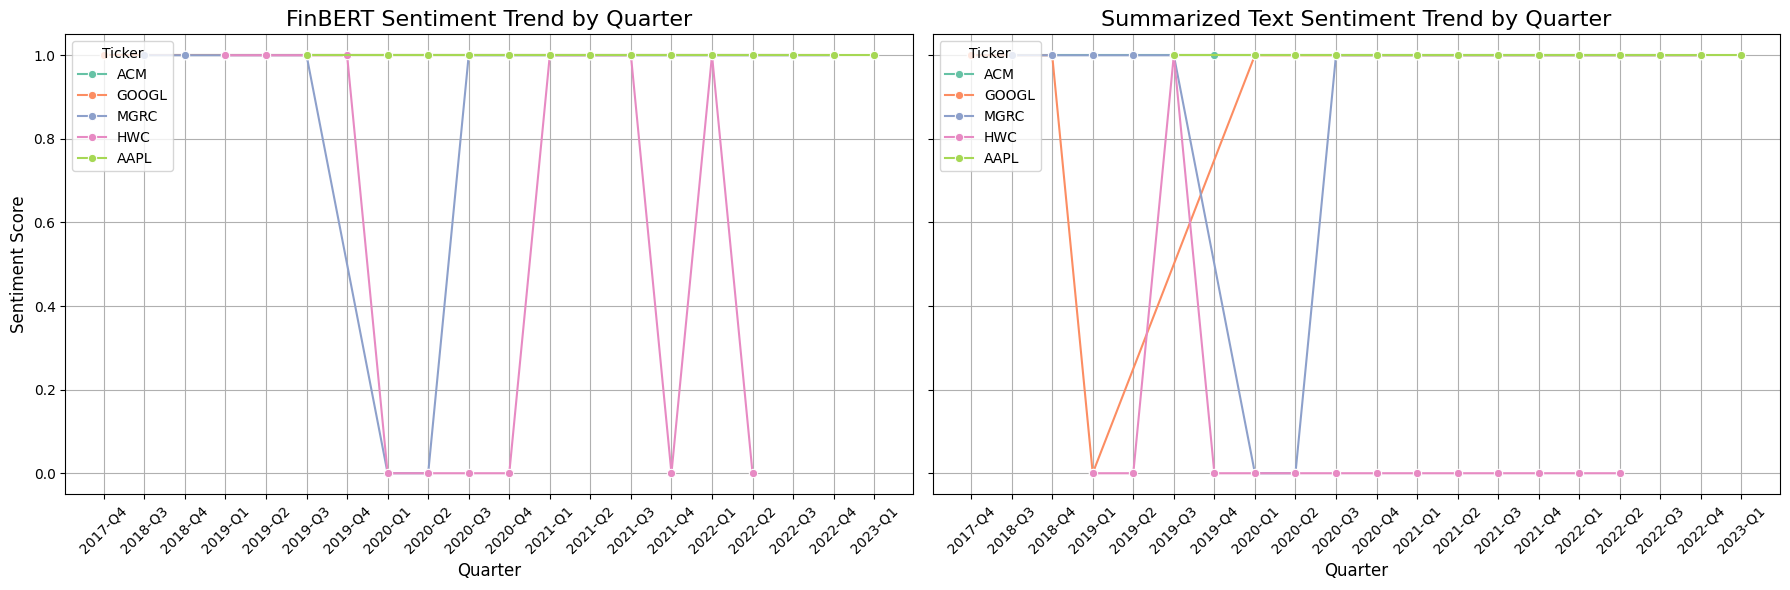

In [79]:
top_tickers = sentiment_over_time['ticker'].value_counts().head(5).index
sentiment_over_time_filtered = sentiment_over_time[sentiment_over_time['ticker'].isin(top_tickers)]

# Set up the figure with two subplots for finbert and key_sentences sentiment
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Line plot for finbert_sentiment
sns.lineplot(data=sentiment_over_time_filtered, x='q', y='finbert_sentiment', 
             hue='ticker', palette='Set2', ax=axes[0], marker='o')
axes[0].set_title("FinBERT Sentiment Trend by Quarter", fontsize=16)
axes[0].set_xlabel("Quarter", fontsize=12)
axes[0].set_ylabel("Sentiment Score", fontsize=12)
axes[0].legend(title="Ticker", loc='upper left')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis for better visibility

# Line plot for key_sentences_sentiment
sns.lineplot(data=sentiment_over_time_filtered, x='q', y='key_sentences_sentiment', 
             hue='ticker', palette='Set2', ax=axes[1], marker='o')
axes[1].set_title("Summarized Text Sentiment Trend by Quarter", fontsize=16)
axes[1].set_xlabel("Quarter", fontsize=12)
axes[1].set_ylabel("Sentiment Score", fontsize=12)
axes[1].legend(title="Ticker", loc='upper left')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for a clean look
plt.tight_layout()

# Show the plots
plt.show()
